<a href="https://colab.research.google.com/github/iyoob-utexas/ds4e/blob/main/notebooks/n7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

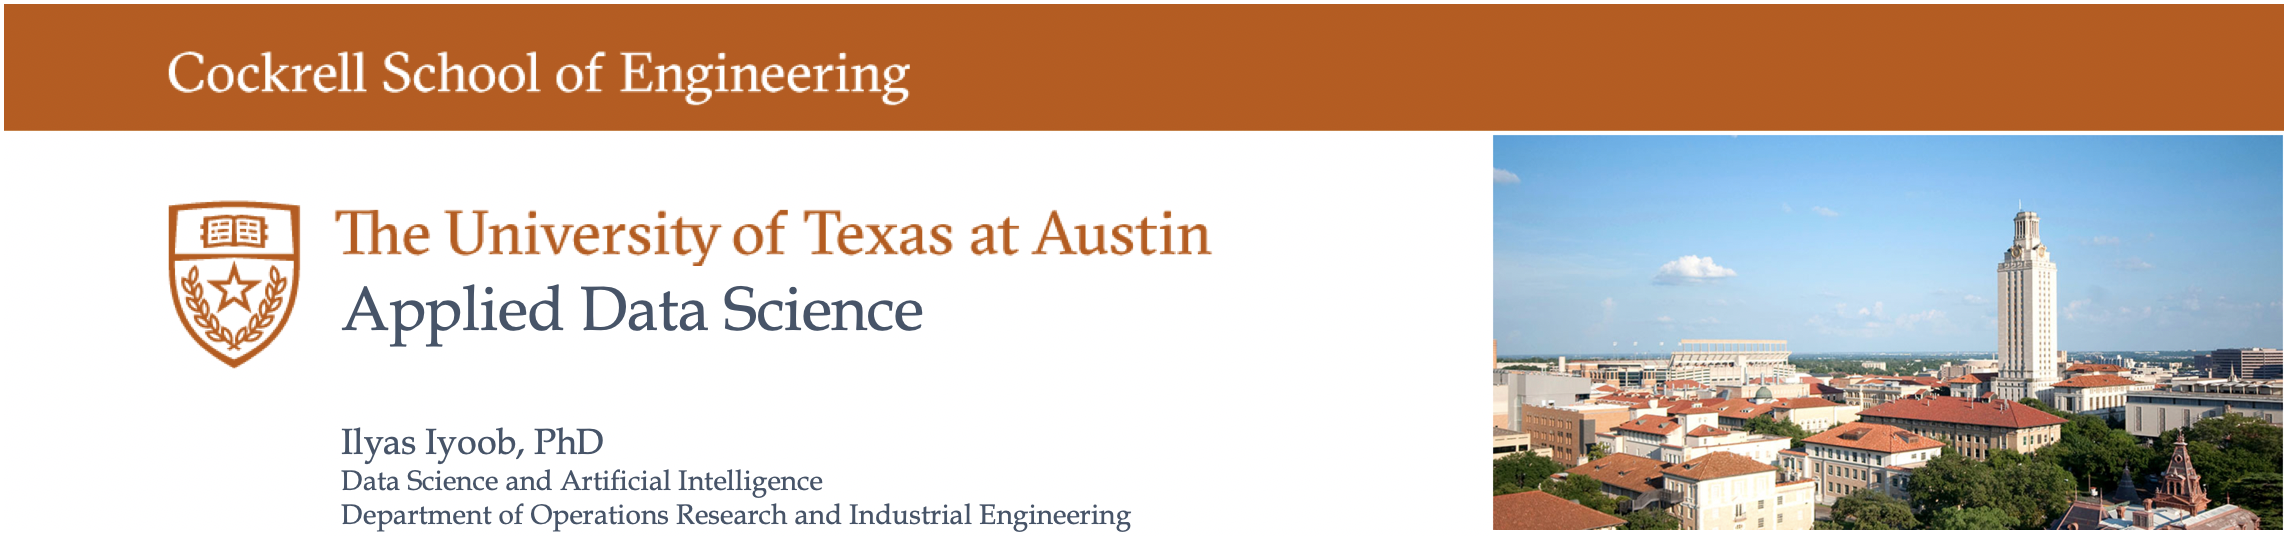

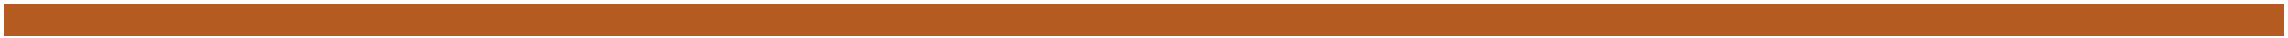

## <font color='#475468'> Bundling Recommendations:</font>
### <font color='#475468'> Can you bundle items that go together based on historical transactions?</font>

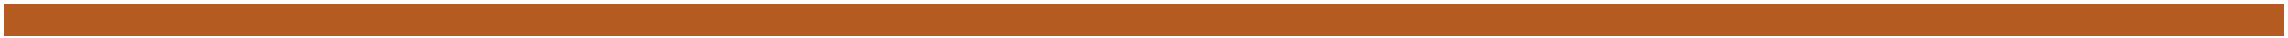

## Initialize

In [ ]:
import pandas as pd

## Load Data

Remember the retail transactions data set that we used for customer segmentation...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dfRet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/retail/retail_transactions.csv', encoding = "ISO-8859-1")

In [ ]:
dfRet.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


WHITEBOARD >>

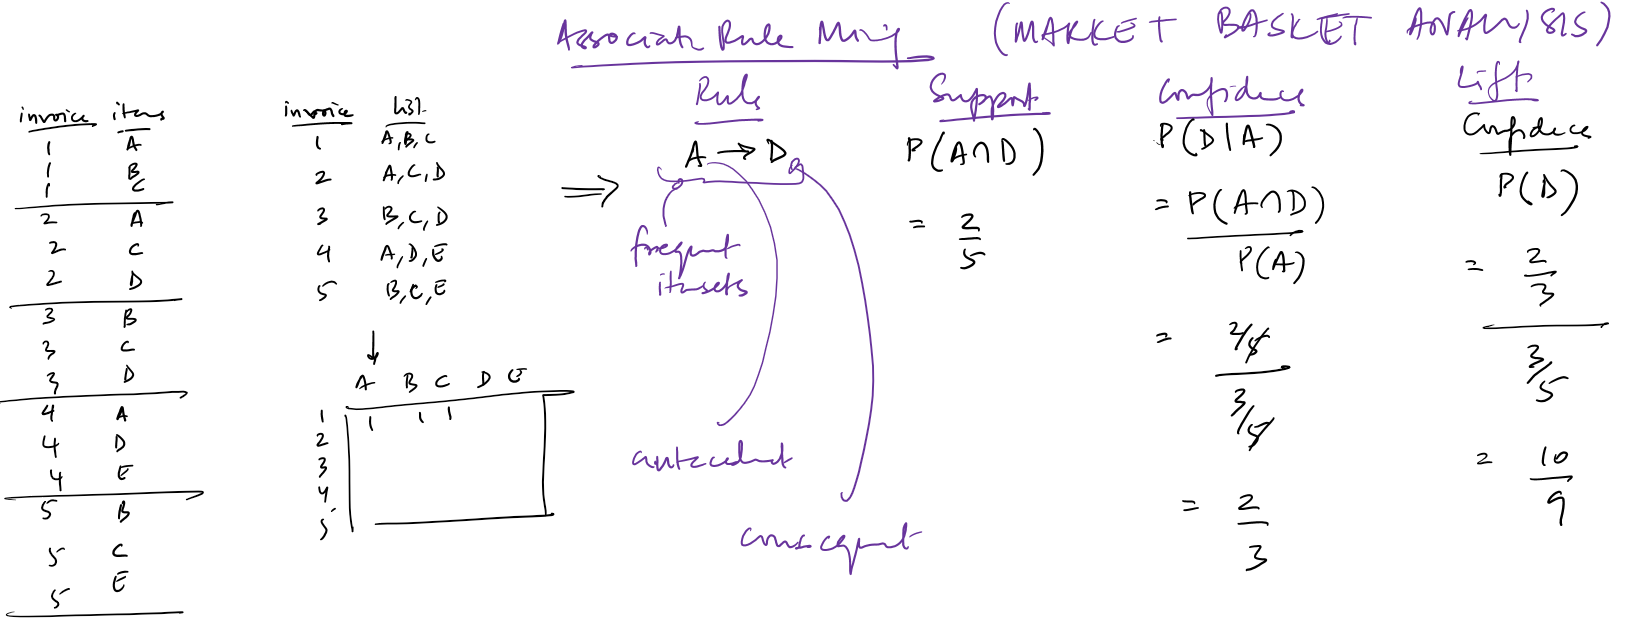

<< WHITEBOARD

Support = how likely is it for both items to show up together
Confidence = how likely is it for D to show up given A showed up
Lift = Confidence compared to D showing up anyway

## Prepare Data

In order to extract relationships between items, the data is first rearranged into a binary table where each transaction is a row, each column is an item, and the values are set to 1 if the item was part of the transaction.

In [ ]:
# Replace spaces and remove characters
dfRet['clean_description'] = dfRet['Description']
dfRet['clean_description'] = dfRet['clean_description'].str.replace(" ", "_")
dfRet['clean_description'].str.replace('\W', '')

0           WHITE_HANGING_HEART_TLIGHT_HOLDER
1                         WHITE_METAL_LANTERN
2              CREAM_CUPID_HEARTS_COAT_HANGER
3         KNITTED_UNION_FLAG_HOT_WATER_BOTTLE
4               RED_WOOLLY_HOTTIE_WHITE_HEART
                         ...                 
541904            PACK_OF_20_SPACEBOY_NAPKINS
541905            CHILDRENS_APRON_DOLLY_GIRL_
541906          CHILDRENS_CUTLERY_DOLLY_GIRL_
541907        CHILDRENS_CUTLERY_CIRCUS_PARADE
541908          BAKING_SET_9_PIECE_RETROSPOT_
Name: clean_description, Length: 541909, dtype: object

In [ ]:
# Drop missing values
dfRet.dropna(inplace=True)

In [ ]:
# Convert to list format
dfRetList=dfRet.groupby('InvoiceNo').clean_description.apply(list)
dfRetList

InvoiceNo
536365     [WHITE_HANGING_HEART_T-LIGHT_HOLDER, WHITE_MET...
536366     [HAND_WARMER_UNION_JACK, HAND_WARMER_RED_POLKA...
536367     [ASSORTED_COLOUR_BIRD_ORNAMENT, POPPY'S_PLAYHO...
536368     [JAM_MAKING_SET_WITH_JARS, RED_COAT_RACK_PARIS...
536369                            [BATH_BUILDING_BLOCK_WORD]
                                 ...                        
C581484                        [PAPER_CRAFT_,_LITTLE_BIRDIE]
C581490    [VICTORIAN_GLASS_HANGING_T-LIGHT, ZINC_T-LIGHT...
C581499                                             [Manual]
C581568                         [VICTORIAN_SEWING_BOX_LARGE]
C581569    [HANGING_HEART_JAR_T-LIGHT_HOLDER, 36_PENCILS_...
Name: clean_description, Length: 22190, dtype: object

Suppose we know what's already in the shopping cart, let's see if we can predict other items that the shopper may add.  This type of analysis is known as **Association Rule Mining** also commonly known as **Market Basket Analysis**.

## Build Model

### Association Rule Mining

Suppose we are interested in the relationship A -> B.  Then:

* **Support**: Fraction of transactions that contain both A and B = Freq(A,B)

* **Confidence**: How often B appears given A appeared = Support / Freq(A)

* **Lift**: Confidence given B appeared = Confidence / Freq(B)

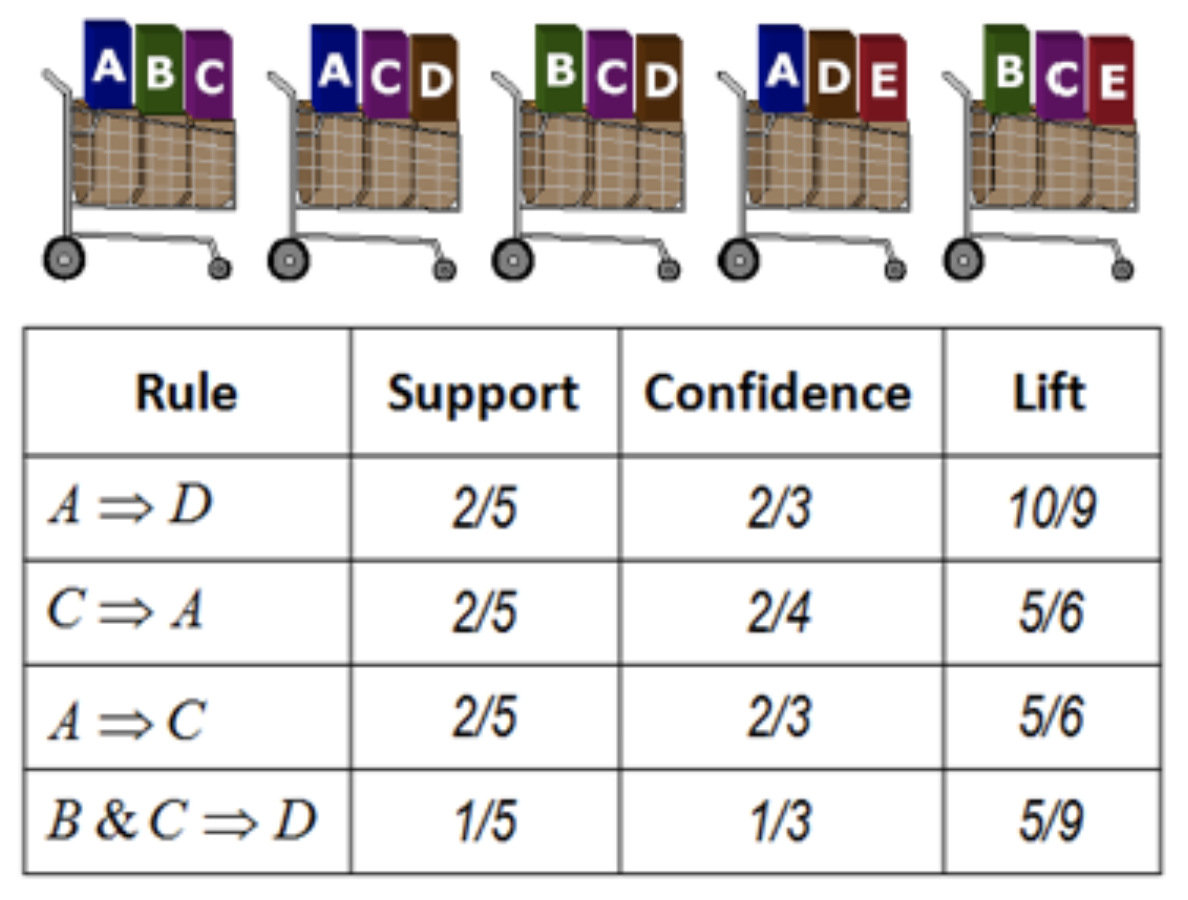

In [ ]:
# Encode data as transaction matrix
from mlxtend.preprocessing import TransactionEncoder

mdlRetTe = TransactionEncoder()
mdlRetTe_array = mdlRetTe.fit(dfRetList).transform(dfRetList)
dfRtb = pd.DataFrame(mdlRetTe_array, columns=mdlRetTe.columns_)
dfRtb

,10_COLOUR_SPACEBOY_PEN,12_COLOURED_PARTY_BALLOONS,12_DAISY_PEGS_IN_WOOD_BOX,12_EGG_HOUSE_PAINTED_WOOD,12_HANGING_EGGS_HAND_PAINTED,12_IVORY_ROSE_PEG_PLACE_SETTINGS,12_MESSAGE_CARDS_WITH_ENVELOPES,12_PENCILS_SMALL_TUBE_RED_RETROSPOT,12_PENCILS_SMALL_TUBE_SKULL,12_PENCILS_TALL_TUBE_POSY,12_PENCILS_TALL_TUBE_RED_RETROSPOT,12_PENCILS_TALL_TUBE_SKULLS,12_PENCILS_TALL_TUBE_WOODLAND,12_PENCIL_SMALL_TUBE_WOODLAND,12_PINK_HEN+CHICKS_IN_BASKET,12_PINK_ROSE_PEG_PLACE_SETTINGS,12_RED_ROSE_PEG_PLACE_SETTINGS,15CM_CHRISTMAS_GLASS_BALL_20_LIGHTS,15_PINK_FLUFFY_CHICKS_IN_BOX,16_PC_CUTLERY_SET_PANTRY_DESIGN,16_PIECE_CUTLERY_SET_PANTRY_DESIGN,18PC_WOODEN_CUTLERY_SET_DISPOSABLE,200_BENDY_SKULL_STRAWS,200_RED_+_WHITE_BENDY_STRAWS,20_DOLLY_PEGS_RETROSPOT,2_DAISIES_HAIR_COMB,2_PICTURE_BOOK_EGGS_EASTER_BUNNY,2_PICTURE_BOOK_EGGS_EASTER_CHICKS,2_PICTURE_BOOK_EGGS_EASTER_DUCKS,36_DOILIES_DOLLY_GIRL,36_DOILIES_VINTAGE_CHRISTMAS,36_FOIL_HEART_CAKE_CASES,36_FOIL_STAR_CAKE_CASES_,36_PENCILS_TUBE_POSY,36_PENCILS_TUBE_RED_RETROSPOT,36_PENCILS_TUBE_SKULLS,36_PENCILS_TUBE_WOODLAND,3D_CHRISTMAS_STAMPS_STICKERS_,3D_DOG_PICTURE_PLAYING_CARDS,3D_HEARTS__HONEYCOMB_PAPER_GARLAND,...,YOU'RE_CONFUSING_ME_METAL_SIGN_,YULETIDE_IMAGES_GIFT_WRAP_SET,YULETIDE_IMAGES_S/6_PAPER_BOXES,ZINC_BOX_SIGN_HOME,ZINC_FINISH_15CM_PLANTER_POTS,ZINC_FOLKART_SLEIGH_BELLS,ZINC_HEARTS_PLANT_POT_HOLDER,ZINC_HEART_FLOWER_T-LIGHT_HOLDER,ZINC_HEART_LATTICE_2_WALL_PLANTER,ZINC_HEART_LATTICE_CHARGER_LARGE,ZINC_HEART_LATTICE_CHARGER_SMALL,ZINC_HEART_LATTICE_T-LIGHT_HOLDER,ZINC_HEART_LATTICE_TRAY_OVAL_,ZINC_HERB_GARDEN_CONTAINER,ZINC_METAL_HEART_DECORATION,ZINC_PLANT_POT_HOLDER,ZINC_STAR_T-LIGHT_HOLDER_,ZINC_SWEETHEART_SOAP_DISH,ZINC_SWEETHEART_WIRE_LETTER_RACK,ZINC_T-LIGHT_HOLDER_STARS_LARGE,ZINC_T-LIGHT_HOLDER_STARS_SMALL,ZINC_T-LIGHT_HOLDER_STAR_LARGE,ZINC_TOP__2_DOOR_WOODEN_SHELF_,ZINC_WILLIE_WINKIE__CANDLE_STICK,ZINC_WIRE_KITCHEN_ORGANISER,ZINC_WIRE_SWEETHEART_LETTER_TRAY,ZINC__HEART_T-LIGHT_HOLDER,ZINC__STAR_T-LIGHT_HOLDER_,_4_PURPLE_FLOCK_DINNER_CANDLES,_50'S_CHRISTMAS_GIFT_BAG_LARGE,_DOLLY_GIRL_BEAKER,_I_LOVE_LONDON_MINI_BACKPACK,_I_LOVE_LONDON_MINI_RUCKSACK,_NINE_DRAWER_OFFICE_TIDY,_OVAL_WALL_MIRROR_DIAMANTE_,_RED_SPOT_GIFT_BAG_LARGE,_SET_2_TEA_TOWELS_I_LOVE_LONDON_,_SPACEBOY_BABY_GIFT_SET,_TOADSTOOL_BEDSIDE_LIGHT_,_TRELLIS_COAT_RACK
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [ ]:
%%time
# Determine the items and itemsets with at least 1% support (generates all itemsets and then filters by support)

from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(dfRtb, min_support=0.01, use_colnames=True)
frequent_itemsets

CPU times: user 1min 12s, sys: 2.54 s, total: 1min 15s
Wall time: 1min 14s


In [ ]:
!pip3 install mlxtend --upgrade

     |████████████████████████████████| 1.3 MB 8.2 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
%%time
# Speed up by using pattern fragment growth method for mining frequent itemsets (uses density to find good itemsets)

from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(dfRtb, min_support=0.01, use_colnames=True)
frequent_itemsets

CPU times: user 3.24 s, sys: 57.1 ms, total: 3.3 s
Wall time: 3.3 s


In [ ]:
# Evaluate the metrics, and filter the items and itemsets that have at least 70% confidence

from mlxtend.frequent_patterns import association_rules

a_rules = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="confidence", min_threshold=0.7)
a_rules.sort_values(by=['confidence'],ascending=False,inplace=True)
a_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
29,"(REGENCY_CAKESTAND_3_TIER, PINK_REGENCY_TEACUP...",(GREEN_REGENCY_TEACUP_AND_SAUCER),0.012213,0.033033,0.010861,0.889299,26.921613,0.010457,8.734936
33,"(PINK_REGENCY_TEACUP_AND_SAUCER, ROSES_REGENCY...",(GREEN_REGENCY_TEACUP_AND_SAUCER),0.020324,0.033033,0.017891,0.880266,26.648164,0.017220,8.075966
27,"(REGENCY_CAKESTAND_3_TIER, GREEN_REGENCY_TEACU...",(ROSES_REGENCY_TEACUP_AND_SAUCER_),0.012348,0.037675,0.010861,0.879562,23.346270,0.010396,7.990217
25,"(REGENCY_CAKESTAND_3_TIER, PINK_REGENCY_TEACUP...",(GREEN_REGENCY_TEACUP_AND_SAUCER),0.014376,0.033033,0.012348,0.858934,26.002386,0.011873,6.854722
26,"(REGENCY_CAKESTAND_3_TIER, PINK_REGENCY_TEACUP...",(ROSES_REGENCY_TEACUP_AND_SAUCER_),0.014376,0.037675,0.012213,0.849530,22.549122,0.011671,6.395454


So, from the first row we see that if someone purchases PINK_REGENCY_TEACUP_AND_SAUCER, REGENCY_CAKESTAND_3_TIER, and ROSES_REGENCY_TEACUP_AND_SAUCER, then they would also purchase GREEN_REGENCY_TEACUP_AND_SAUCER with 89% confidence.

utexas_ds_orie_divider_gray.png

## Takeaways

* Introduced association rule mining to recommend item bundles using *Market Basket Analysis*
* Evaluated item bundles using *Support*, *Confidence*, and *Lift* metrics

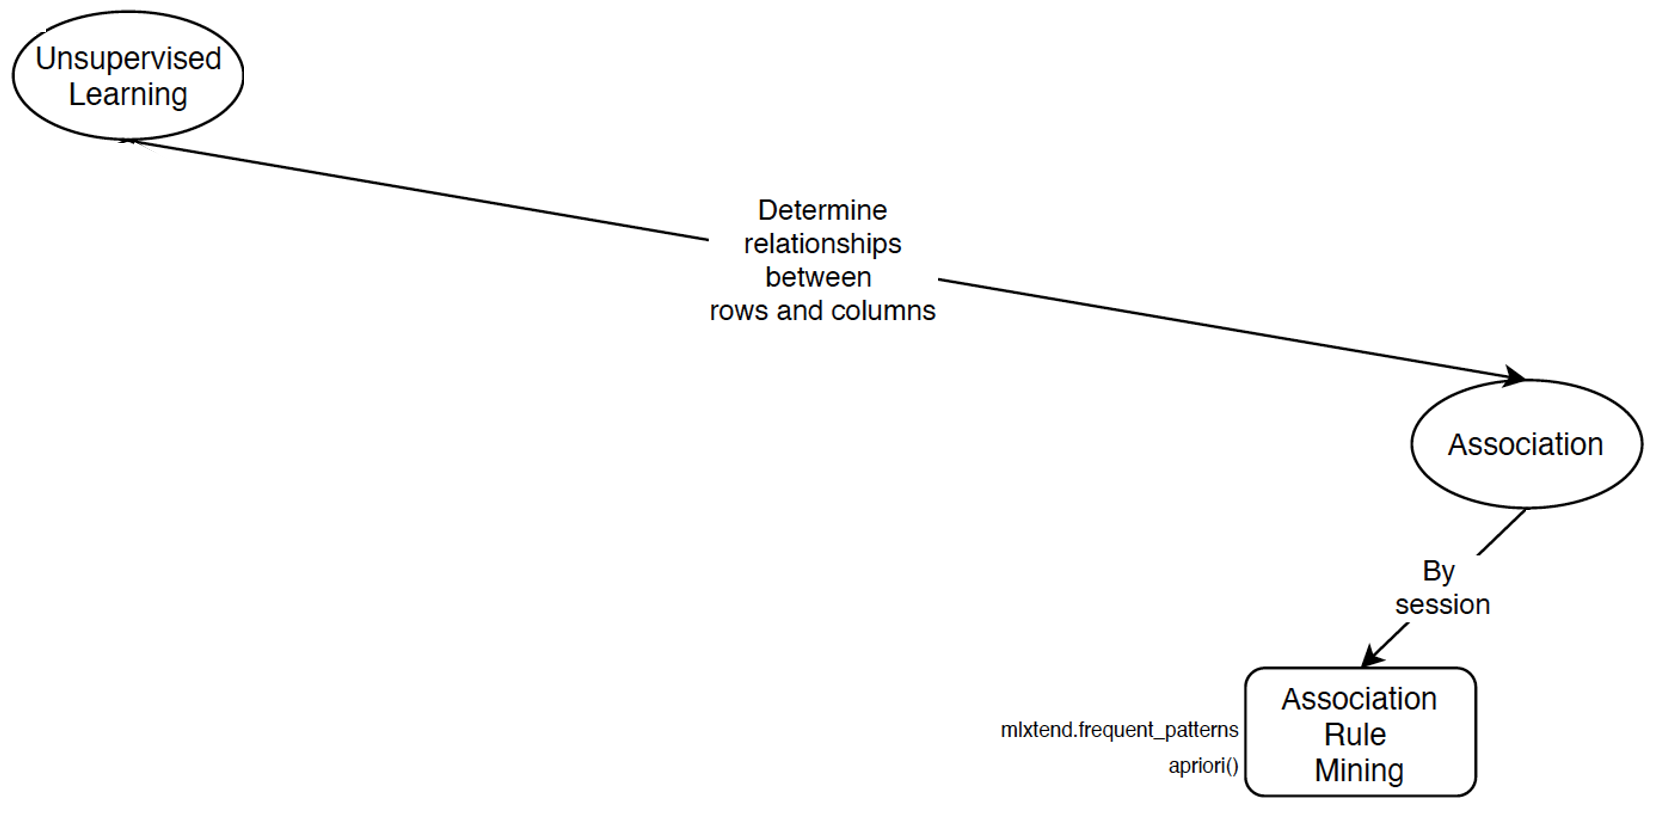

Intro to processing columns i.e. Features:

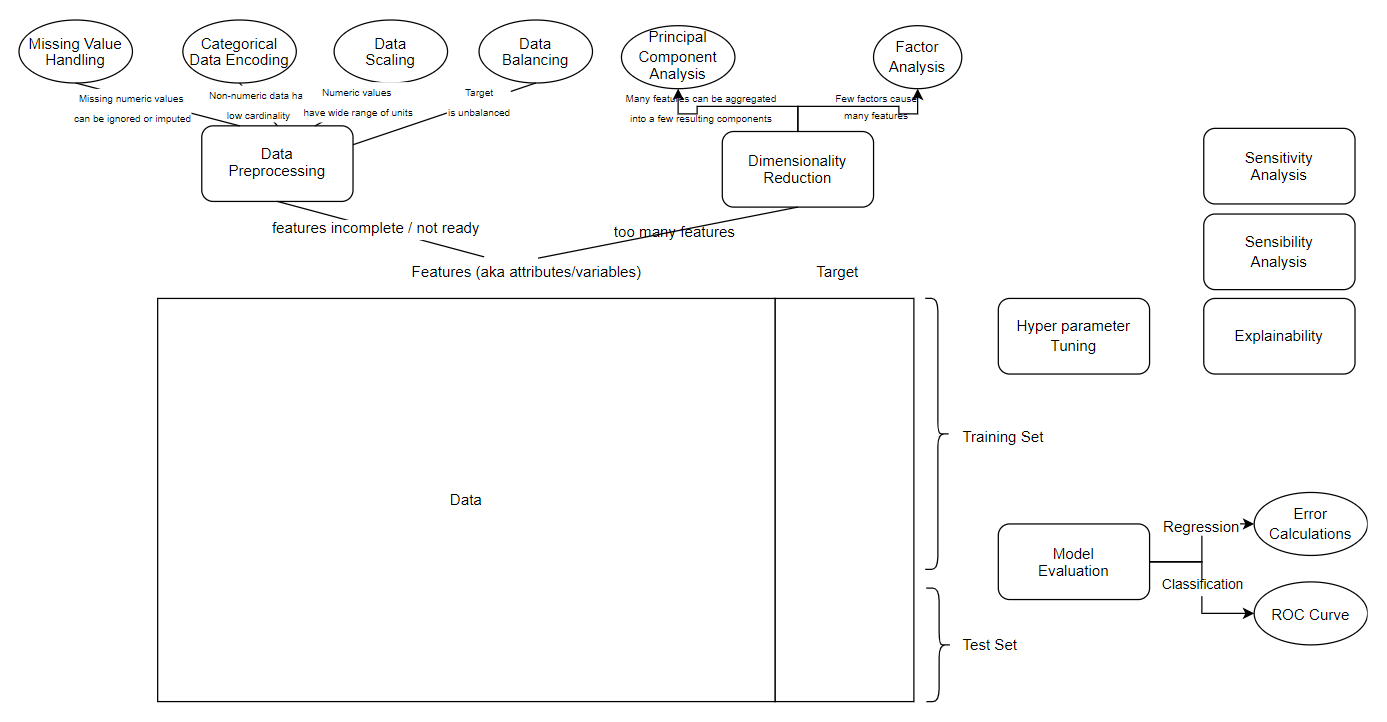

Difference between PCA and Factor Analysis:

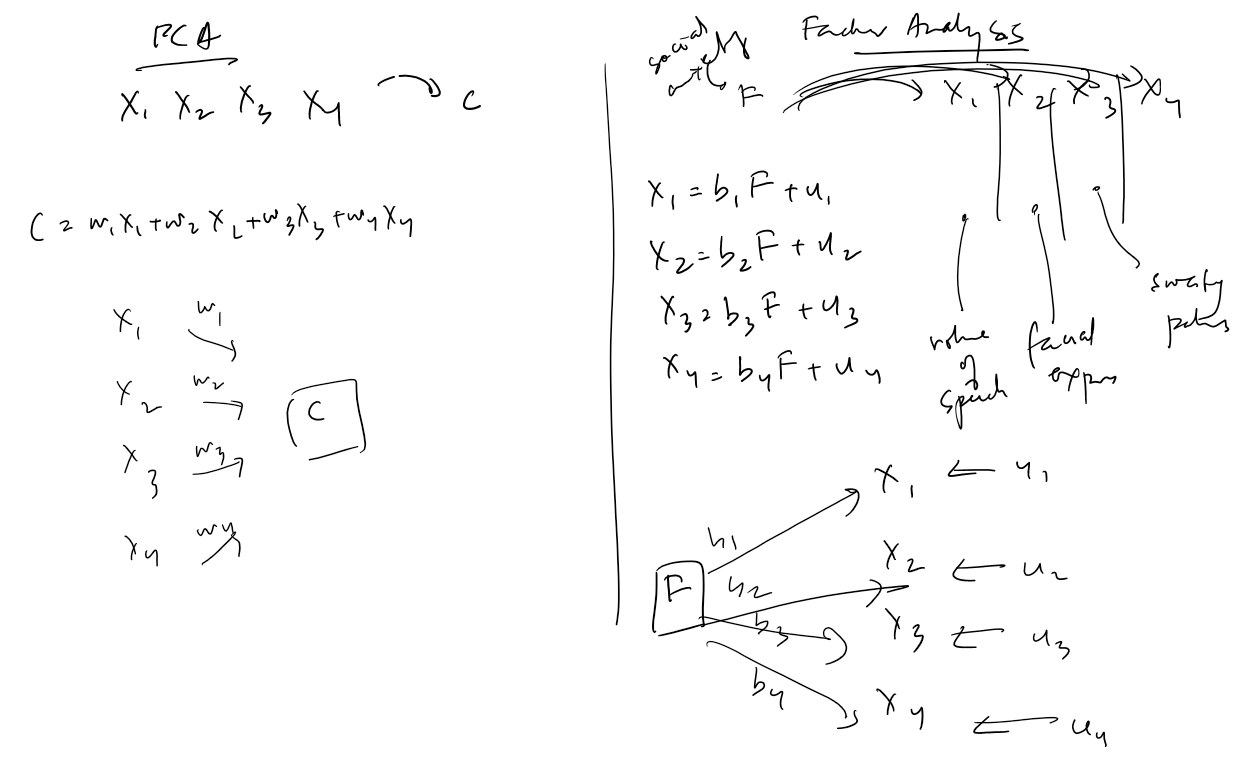

Combining it together in the mindmap:

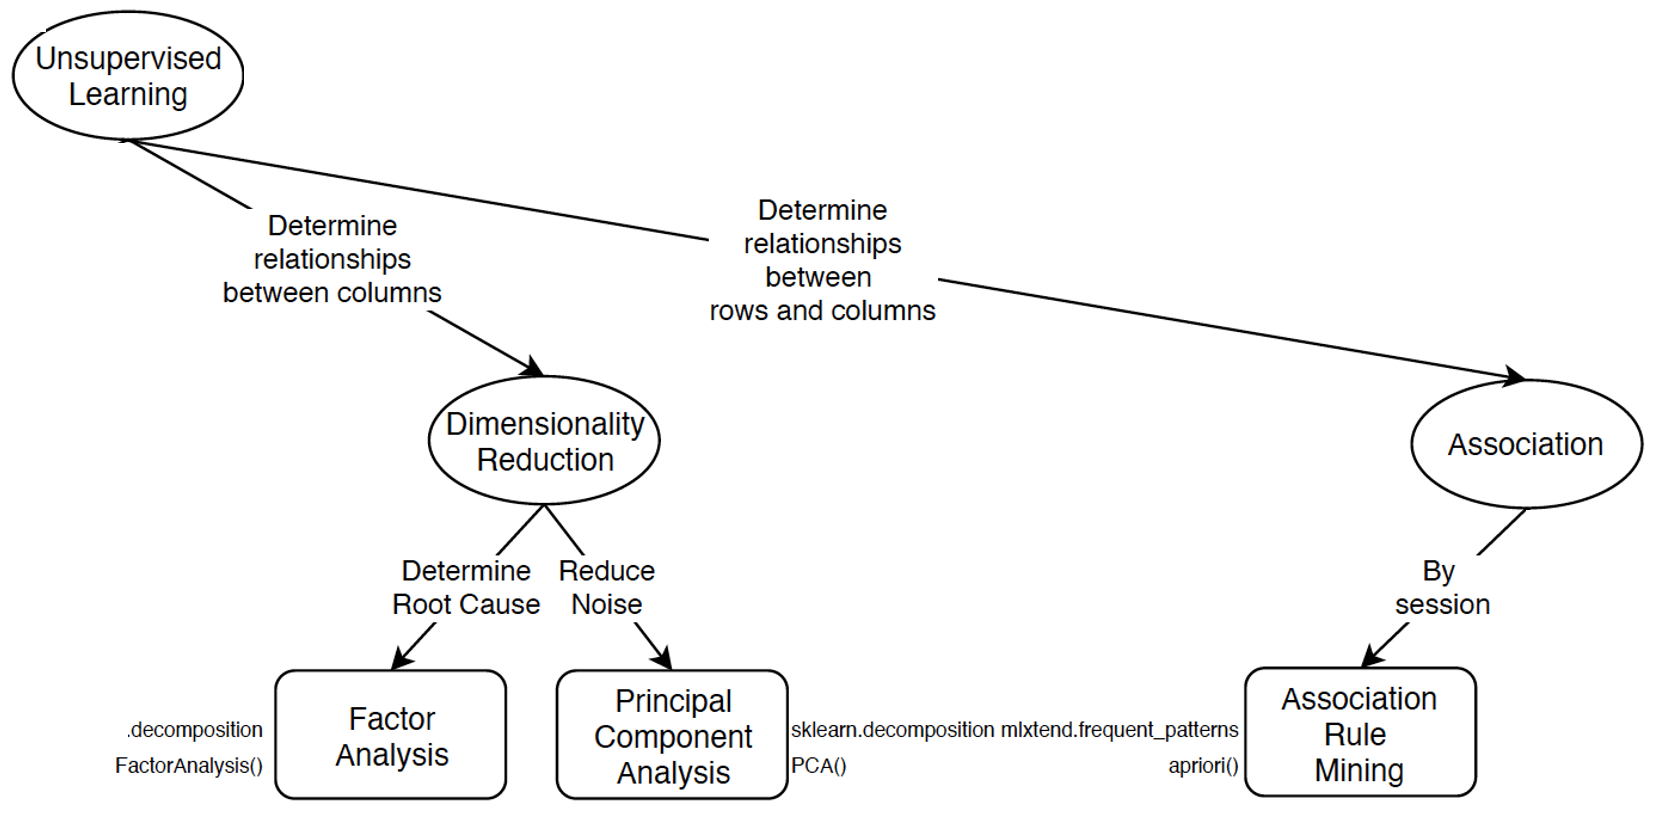

<< WHITEBOARD

utexas_ds_orie_divider_gray.png